# Uncertainty demo: how to build a neural network that knows when it doesn't know
* Based on 2D toy datasets
* Classification problems
* Contrasts approximate Bayesian methods (MC dropout), empirically strong baselines on high-dimensional data (deep ensembles) with distance-aware methods (recent developments)
* This notebook constitutes the practical demo for [_Towards a scalable deployment of AI models via Uncertainty Quantification_, _Open Data Science Conference, London 2022_](https://odsc.com/speakers/towards-a-scalable-deployment-of-ai-models-via-uncertainty-quantification/). See the accompanying slide deck for background and references to literature.
* A very similar tutorial, but for SNGP using Gaussian Processes instead of simpler density models can be found at: https://www.tensorflow.org/tutorials/understanding/sngp

In [2]:
from typing import Dict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.datasets
import tensorflow as tf
from tqdm import tqdm
import official.nlp.modeling.layers as nlp_layers

In [3]:
sns.set(font_scale=2.0)
sns.set_style("white")

## Data

In [4]:
X1_RANGE = (-3, 3)
X2_RANGE = (-3, 3)
N_GRID = 100


def generate_train_data(n_samples=1000, dataset="moons"):
    if dataset == "moons":
        return sklearn.datasets.make_moons(n_samples=n_samples, noise=0.1)
    elif dataset == "circles":
        return sklearn.datasets.make_circles(n_samples=n_samples, noise=0.1)


def generate_test_data():
    x1 = np.linspace(X1_RANGE[0], X1_RANGE[1], N_GRID)
    x2 = np.linspace(X2_RANGE[0], X2_RANGE[1], N_GRID)
    x1v, x2v = np.meshgrid(x1, x2)
    return np.c_[x1v.flatten(), x2v.flatten()]


def plot_training_data(X_train, y_train, ax):
    colors = sns.color_palette()
    for k in classes:
        ax.scatter(X_train[y_train==k, 0], X_train[y_train==k, 1], color=colors[k], label='class %d' %k)
    ax.legend()
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

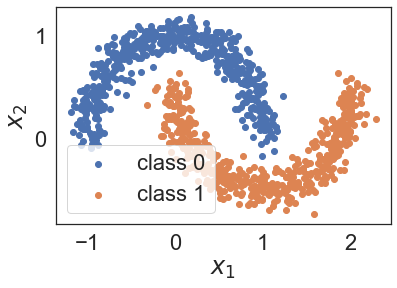

In [5]:
X_train, y_train = generate_train_data(dataset="moons")
X_test = generate_test_data()
classes = np.unique(y_train)

fig = plt.figure()
plot_training_data(X_train, y_train, plt.gca())

## Models

We start by defining some functions that we will reuse throughout for different models:
* All models will be deep neural networks with the same overall architecture (number of layers and units per layer) that will just differ in terms of their hidden layer specification
* All models will be trained with the same hyperparameters

In [6]:
def build_model(layer_class: tf.keras.layers.Layer, layer_config={}, n_features=2, n_classes=2, n_layers=8) -> tf.keras.Model:
    
    inputs = tf.keras.Input(shape=(n_features,))
    # Projection of input to n_hidden dimensions such that layer can apply skip connections
    x = tf.keras.layers.Dense(layer_config.get("n_hidden", 128), trainable=False)(inputs)
    
    for _ in range(n_layers):
        x = layer_class(**layer_config)(x)
    logits = tf.keras.layers.Dense(n_classes)(x)
    score = tf.keras.activations.softmax(logits, axis=-1)[:, 0]  # 0th class score

    return tf.keras.Model(inputs=inputs, outputs={"features": x, "logits": logits, "score": score})

In [7]:
def train(model: tf.keras.Model, X_train: np.ndarray, y_train: np.ndarray):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss={"logits": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)}
    )
    model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=0)

### Deterministic MLP

In [8]:
class MLPLayer(tf.keras.layers.Layer):
    """Dense layer with dropout for building a standard multi-layer perceptron"""
    
    def __init__(self, n_hidden=128, dropout_rate=0.1):
        super().__init__()
        self.dense = tf.keras.layers.Dense(n_hidden, activation="relu")
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, inputs):
        x = self.dense(inputs)
        return self.dropout(x)

In [9]:
model = build_model(MLPLayer)

2022-06-16 19:13:09.193505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 mlp_layer (MLPLayer)        (None, 128)               16512     
                                                                 
 mlp_layer_1 (MLPLayer)      (None, 128)               16512     
                                                                 
 mlp_layer_2 (MLPLayer)      (None, 128)               16512     
                                                                 
 mlp_layer_3 (MLPLayer)      (None, 128)               16512     
                                                                 
 mlp_layer_4 (MLPLayer)      (None, 128)               16512 

In [11]:
train(model, X_train, y_train)

## Quantifying uncertainty
Some measures that are useful for aleatoric uncertainty, but not necessarily for epistemic uncertainty as demonstrated below. As long as they don't change the rank order, it does not really matter which one we take for aleatoric uncertainty.

In [12]:
def binary_entropy(p):
    eps = np.finfo(float).eps
    return -(p * np.log2(p + eps) + (1 - p) * np.log2((1 - p) + eps))


def binary_variance(p):
    return p * (1 - p)

## Visualizing predictions and uncertainty

In [13]:
def visualize_scores(scores, ax):
        
    # Score surface
    score_surface = ax.imshow(
        scores.reshape([N_GRID, N_GRID]),
        interpolation="bicubic",
        origin="lower",
        extent=X1_RANGE + X2_RANGE,
    )
    fig.colorbar(score_surface, ax=ax)
    
    # Training data
    plot_training_data(X_train, y_train, ax)


def visualize_predictions_and_uncertainty(y_score_test: np.ndarray, uncertainties: Dict[str, np.ndarray]):
    
    n_uncertainties = len(uncertainties.keys())
    n_cols = 1 + n_uncertainties
    fig, axs = plt.subplots(1, n_cols, figsize=(14 * n_cols, 10))
    
    visualize_scores(y_score_test, axs[0])
    axs[0].set_title("Model scores p(y|x)")
    
    for i, (name, uncertainty) in enumerate(uncertainties.items()): 
        visualize_scores(uncertainty, axs[i + 1])
        axs[i + 1].set_title(f"Uncertainty ({name})")

In [14]:
outputs_test = model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


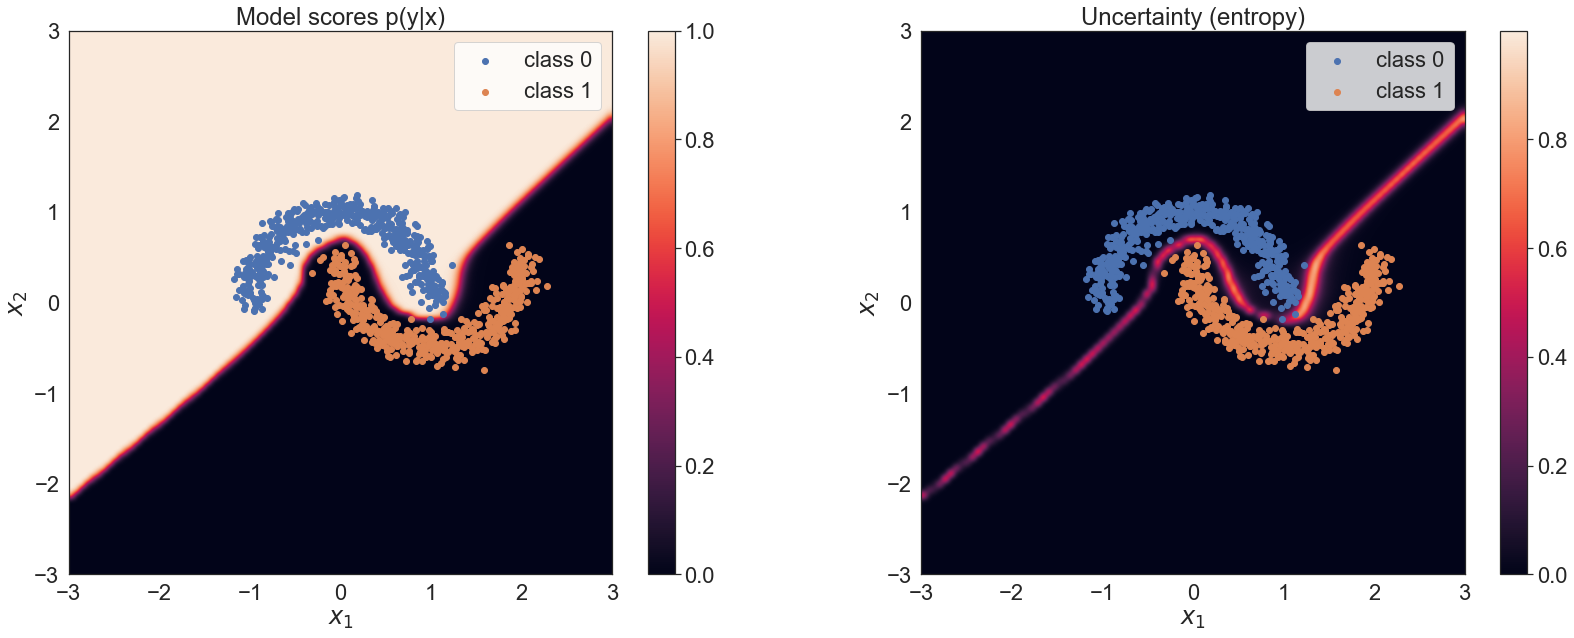

In [15]:
visualize_predictions_and_uncertainty(outputs_test["score"], {"entropy": binary_entropy(outputs_test["score"])})

## MC dropout

In [16]:
def mc_dropout_predictive_mean(model, X_test, n_samples=10):
    
    def mc_sample():
        return model(X_test, training=True)["score"].numpy()
    
    return np.mean([mc_sample() for _ in range(n_samples)], axis=0)

In [17]:
score = mc_dropout_predictive_mean(model, X_test)

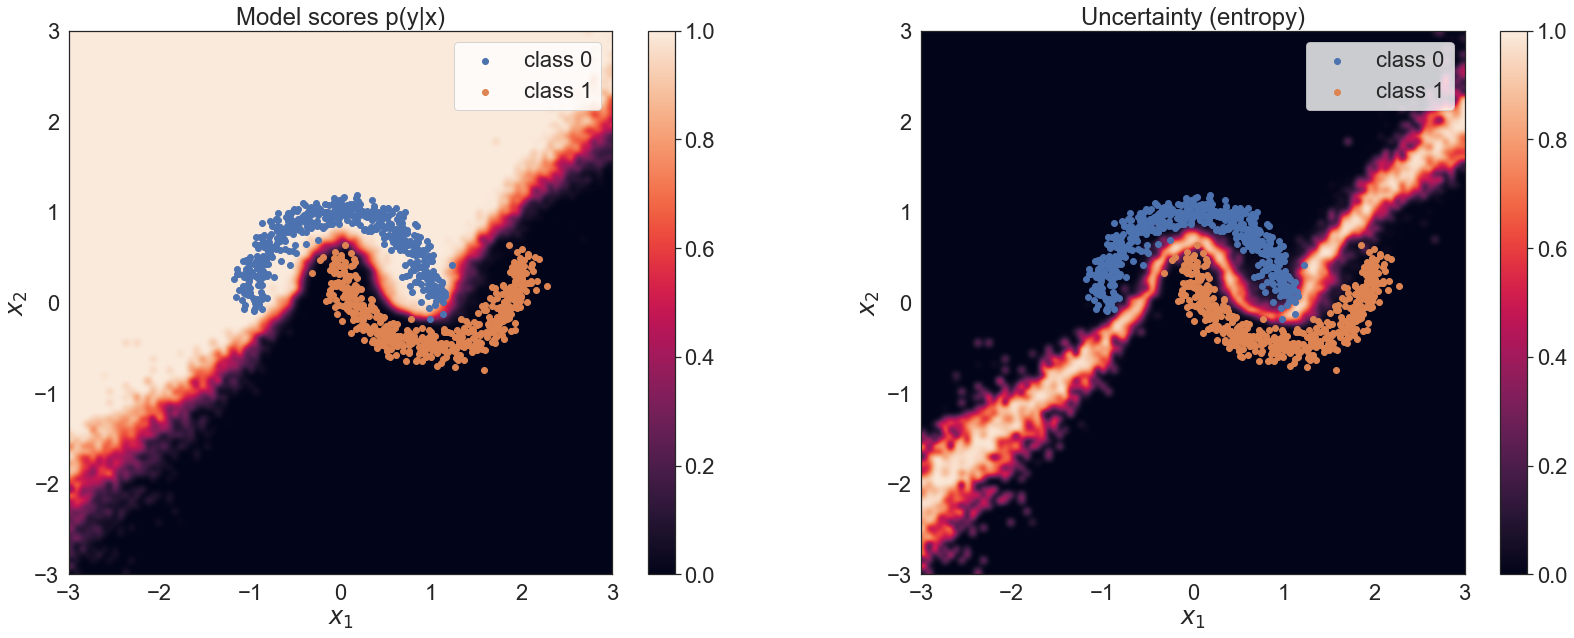

In [18]:
visualize_predictions_and_uncertainty(score, {"entropy": binary_entropy(score)})

## Deep ensembling

In [19]:
def train_ensemble(X_train, y_train, n_members=5):
    trained_models = []
    for _ in tqdm(range(n_members)):
        model = build_model(MLPLayer, layer_config={})
        train(model, X_train, y_train)
        trained_models.append(model)
    return trained_models


def ensemble_predictive_mean(models, X_test):
    return np.mean([model.predict(X_test)["score"] for model in models], axis=0)

In [20]:
trained_models = train_ensemble(X_train, y_train, n_members=5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.11s/it]


In [21]:
score = ensemble_predictive_mean(trained_models, X_test)

313/313 [==============================] - 0s 1ms/step


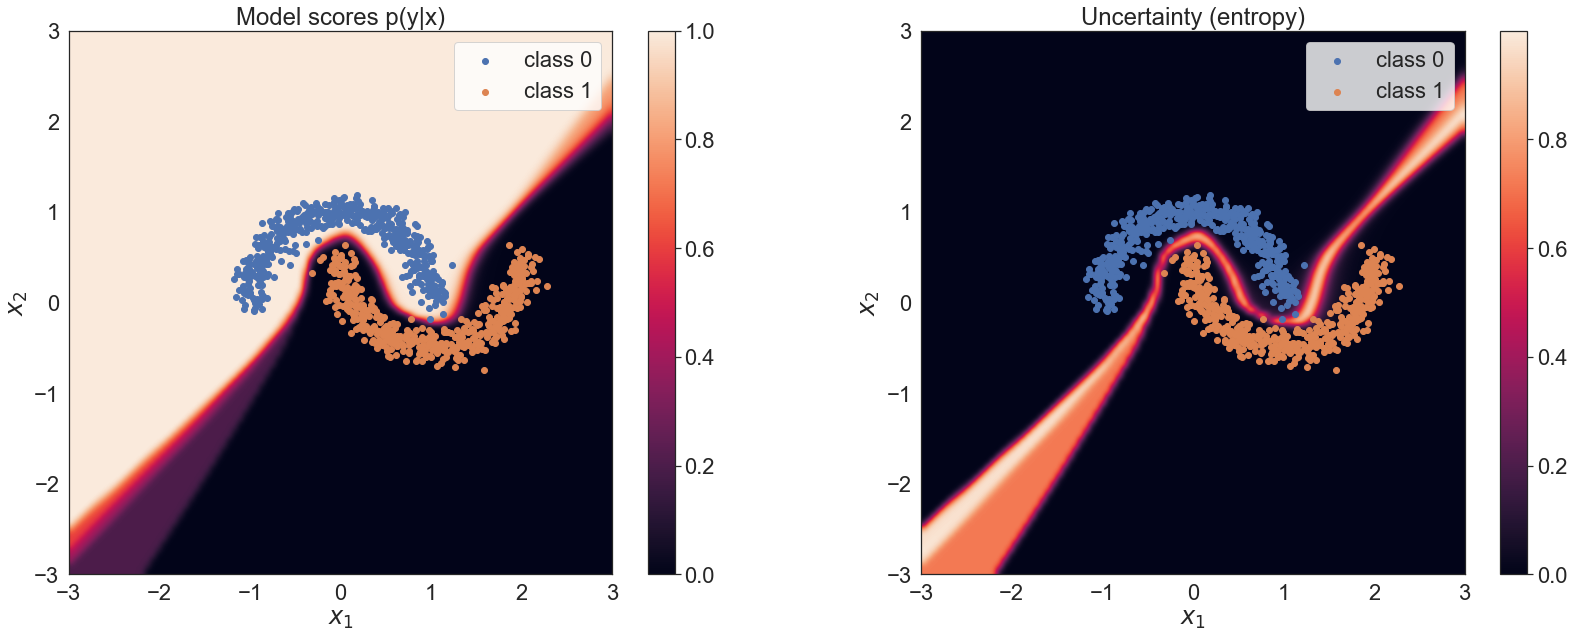

In [22]:
visualize_predictions_and_uncertainty(score, {"entropy": binary_entropy(score)})

## Distance-aware uncertainty

### (Spectrally normalized) ResNet

In [23]:
class ResNetSNLayer(MLPLayer):
    """Same as a hidden layer for a MLP, but spectrally normalized and with skip connections"""
    
    def __init__(self, norm_multiplier=0.9, **kwargs):
        super().__init__(**kwargs)
        self.spectrally_normalised_dense = nlp_layers.SpectralNormalization(
            self.dense, norm_multiplier=norm_multiplier)
    
    def call(self, inputs):
        x = self.spectrally_normalised_dense(inputs)
        x = self.dropout(x)
        return inputs + x
    

class ResNetLayer(MLPLayer):
    """Same as a hidden layer for a MLP, but with a skip connection"""
    
    def call(self, inputs):
        return inputs + super().call(inputs)

In [24]:
model = build_model(ResNetSNLayer, layer_config={}, n_layers=8)

In [25]:
train(model, X_train, y_train)

In [26]:
outputs_test = model.predict(X_test)

313/313 [==============================] - 1s 1ms/step


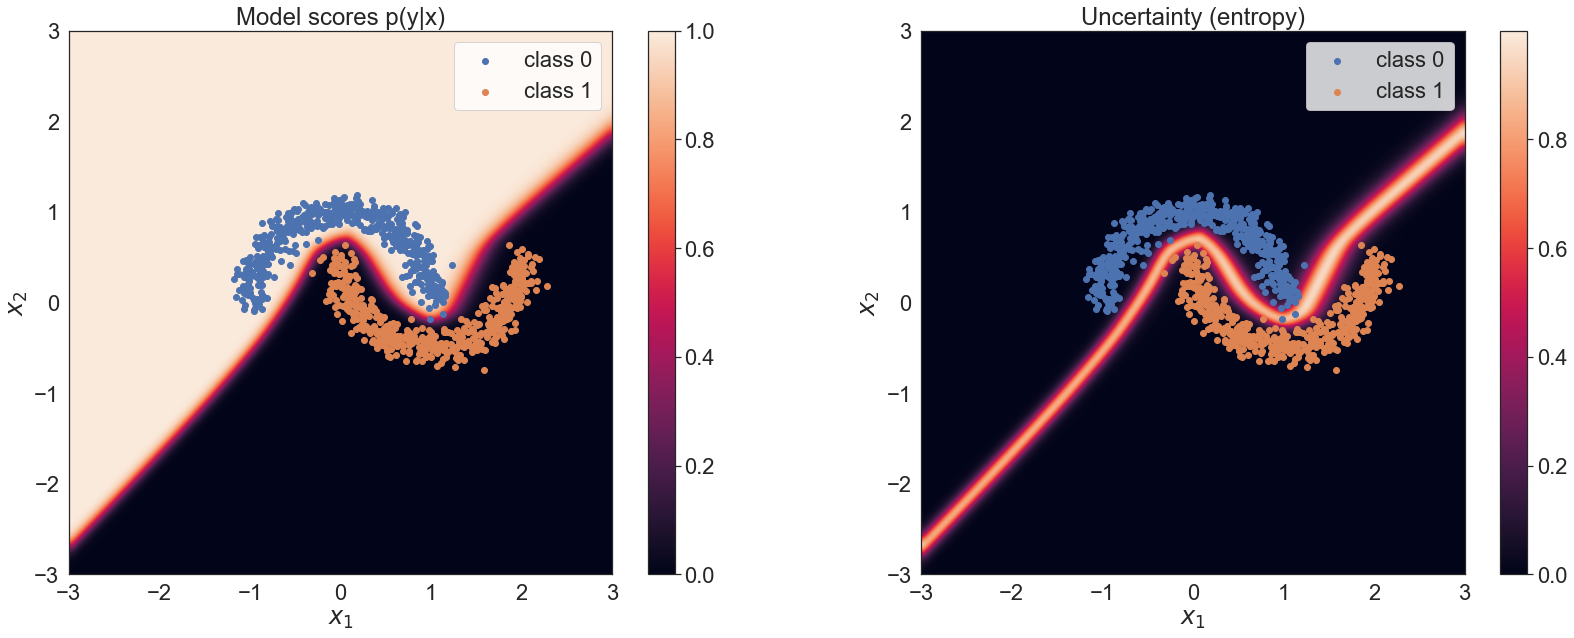

In [27]:
visualize_predictions_and_uncertainty(outputs_test["score"], {"entropy": binary_entropy(outputs_test["score"])})

### Some simple density / OOD models
Following the thoughts of [Mukhoti et al. 2022: Deep Deterministic Uncertainty: A Simple Baseline](https://arxiv.org/pdf/2102.11582v3.pdf#cite.van2021improving). For [Liu et al. 2020: Simple and Principled Uncertainty Estimation with Deterministic Deep Learning via Distance Awareness, NeurIPS](https://proceedings.neurips.cc/paper/2020/hash/543e83748234f7cbab21aa0ade66565f-Abstract.html), see the SNGP tutorial [here](https://www.tensorflow.org/tutorials/understanding/sngp). For followup work using GPs, see [here](https://github.com/y0ast/DUE).

In [28]:
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

In [29]:
class GMM:
    """Gaussian mixture model
    
    with one component per ground truth class.
    
    Using the ground truth information from training data
    avoids the costly unsupervised component assignment via EM
    
    """
    
    def fit(self, X_train, y_train):
        
        classes = np.unique(y_train)
        n_classes = len(classes)
        n_total, n_features = X_train.shape
        
        self.pi = np.zeros(n_classes)
        self.components = []

        for i, k in enumerate(classes):
            n_k = sum(y_train == k)
            self.pi[i] = n_k / n_total
            X_k = X_train[y_train == k]
            self.components.append(
                multivariate_normal(
                    mean=np.mean(X_k, axis=0), 
                    cov=np.cov(X_k.T),
                    allow_singular=True,  # depends on numerical definition
                )
            )
            
        return self
        
    def score_samples(self, X_test):
        """Compute log-density for each sample"""
        # We compute everything in log space to avoid numerical instabilities
        log_p_per_component = [np.log(pi_k) + component.logpdf(X_test) for pi_k, component in zip(self.pi, self.components)]
        return np.logaddexp(*log_p_per_component)

In [30]:
outputs_train = model.predict(X_train)

32/32 [==============================] - 0s 1ms/step


In [31]:
def threshold_and_normalize_score(score, minimum):
    """Normalize to make different uncertainty quantification approaches comparable"""
    score = score.copy()
    # Pin minimum to that of training data as we 
    # are not interested in differences outside of
    # training distribution
    score[score<=minimum] = minimum
    # Scale to [0, 1] interval 
    score -= minimum
    score /= score.max()
    # Reverse scale such that OoD samples achieve high scores
    return 1 - score

In [32]:
feat_train, feat_test = outputs_train["features"], outputs_test["features"]

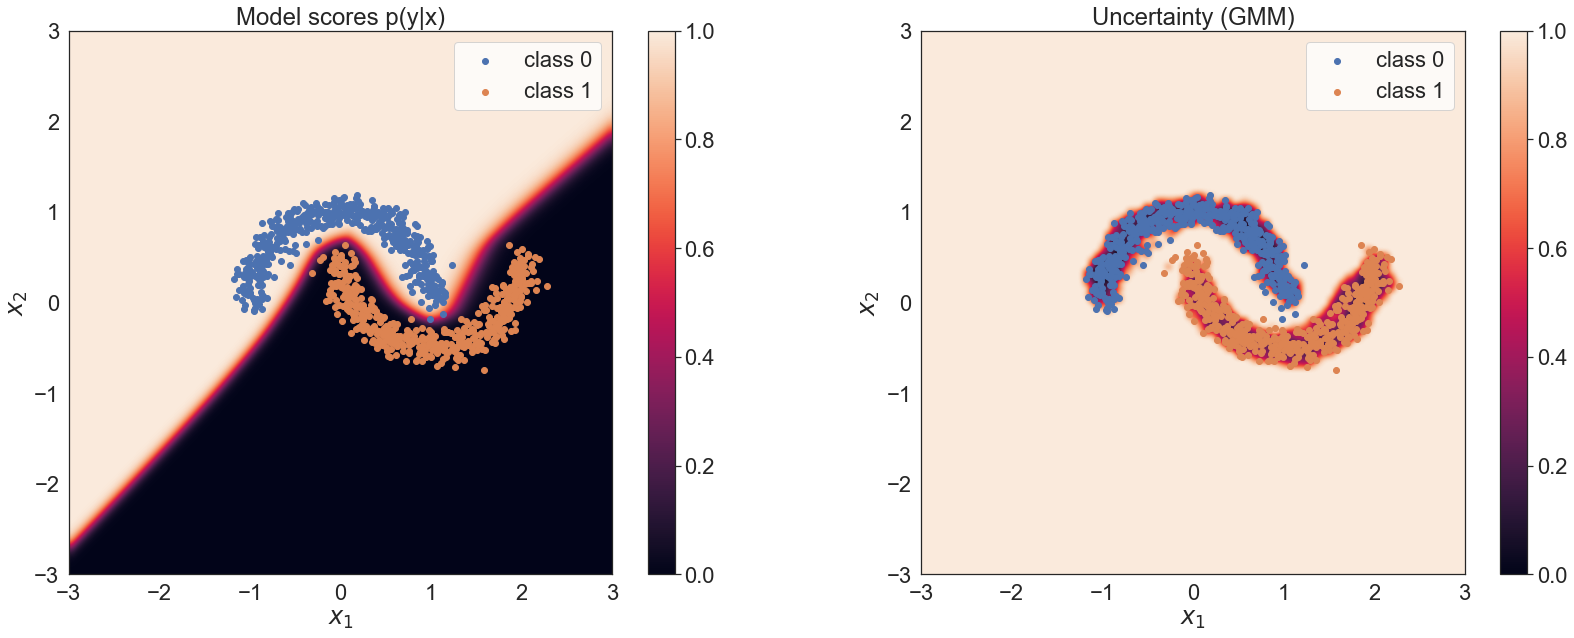

In [33]:
scorer = GMM().fit(feat_train, y_train)
#scorer = GaussianMixture(n_components=2).fit(feat_train)

score_test = scorer.score_samples(feat_test)
score_train = scorer.score_samples(feat_train)
visualize_predictions_and_uncertainty(
    outputs_test["score"],
    {scorer.__class__.__name__: threshold_and_normalize_score(score_test, minimum=score_train.min())}
)

### Ablations
Hyperparameters that are interesting to vary: 
* Network capacity (number of layers and units)
* Layer architecture (with/without skip connections, spectral normalisation)
* Type of density model

In [34]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [35]:
def train_and_evaluate(layers, scorers, n_layers):
    
    for layer_class, layer_config in layers:
        model = build_model(layer_class, layer_config=layer_config, n_layers=n_layers)
        train(model, X_train, y_train)

        outputs_train = model.predict(X_train)
        outputs_test = model.predict(X_test)
    
        # Distance-aware uncertainties
        uncertainties = {}
        for scorer in scorers:
            scorer = scorer.fit(outputs_train["features"])
            score_train = scorer.score_samples(outputs_train["features"])
            score_test = scorer.score_samples(outputs_test["features"])
            uncertainties[scorer.__class__.__name__] = threshold_and_normalize_score(score_test, minimum=score_train.min())
        
        visualize_predictions_and_uncertainty(outputs_test["score"], uncertainties)
        plt.suptitle(f"Discriminative feature space [layer]: {layer_class.__name__}", size="xx-large")

313/313 [==============================] - 1s 2ms/step


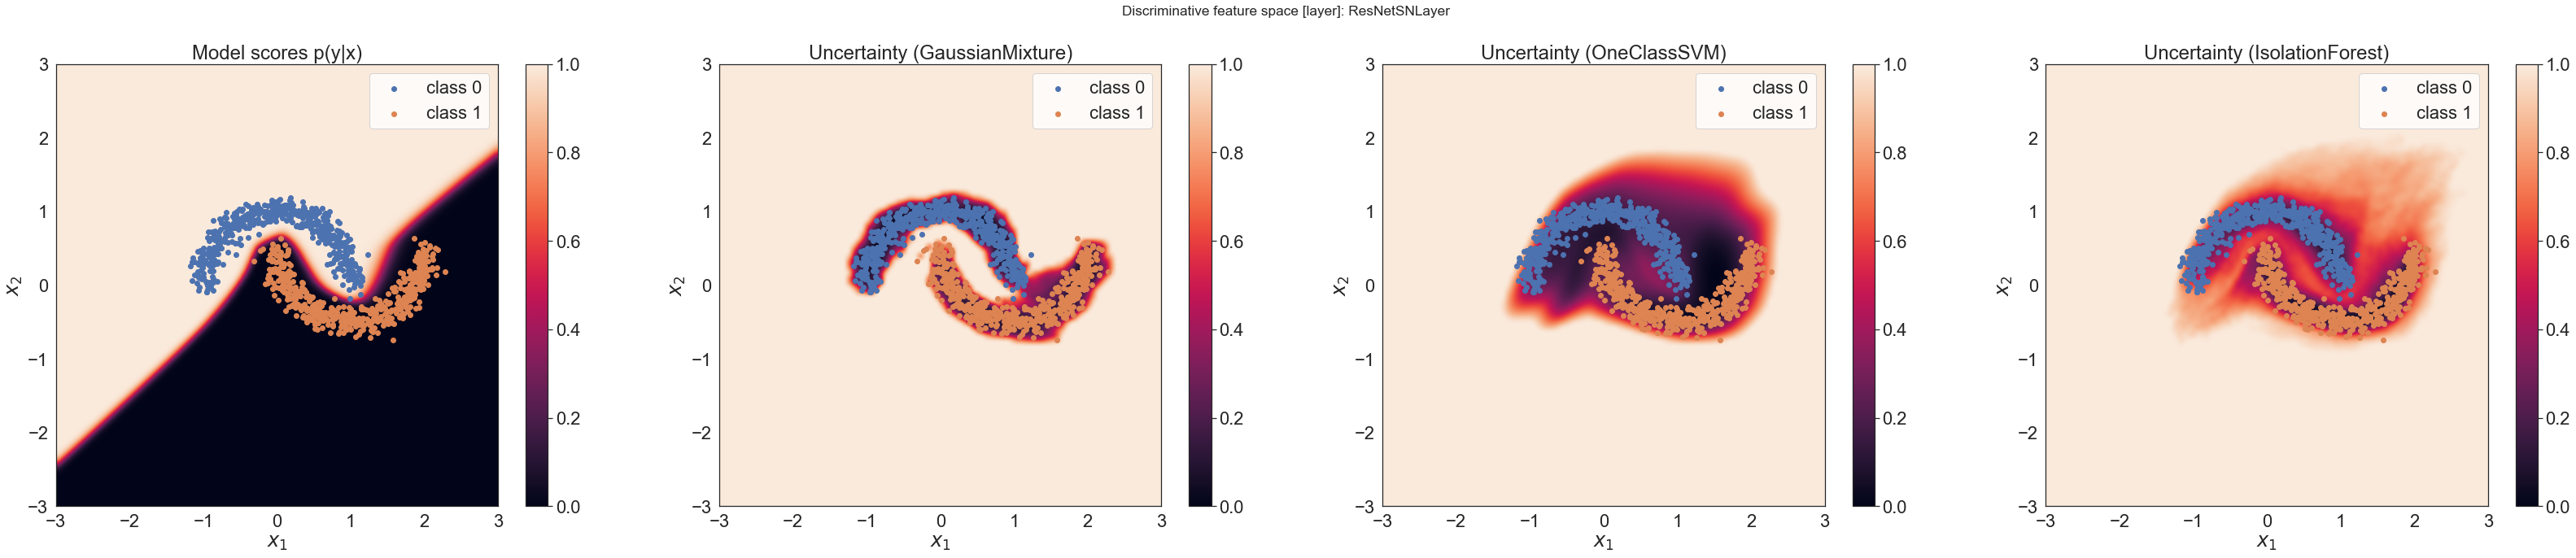

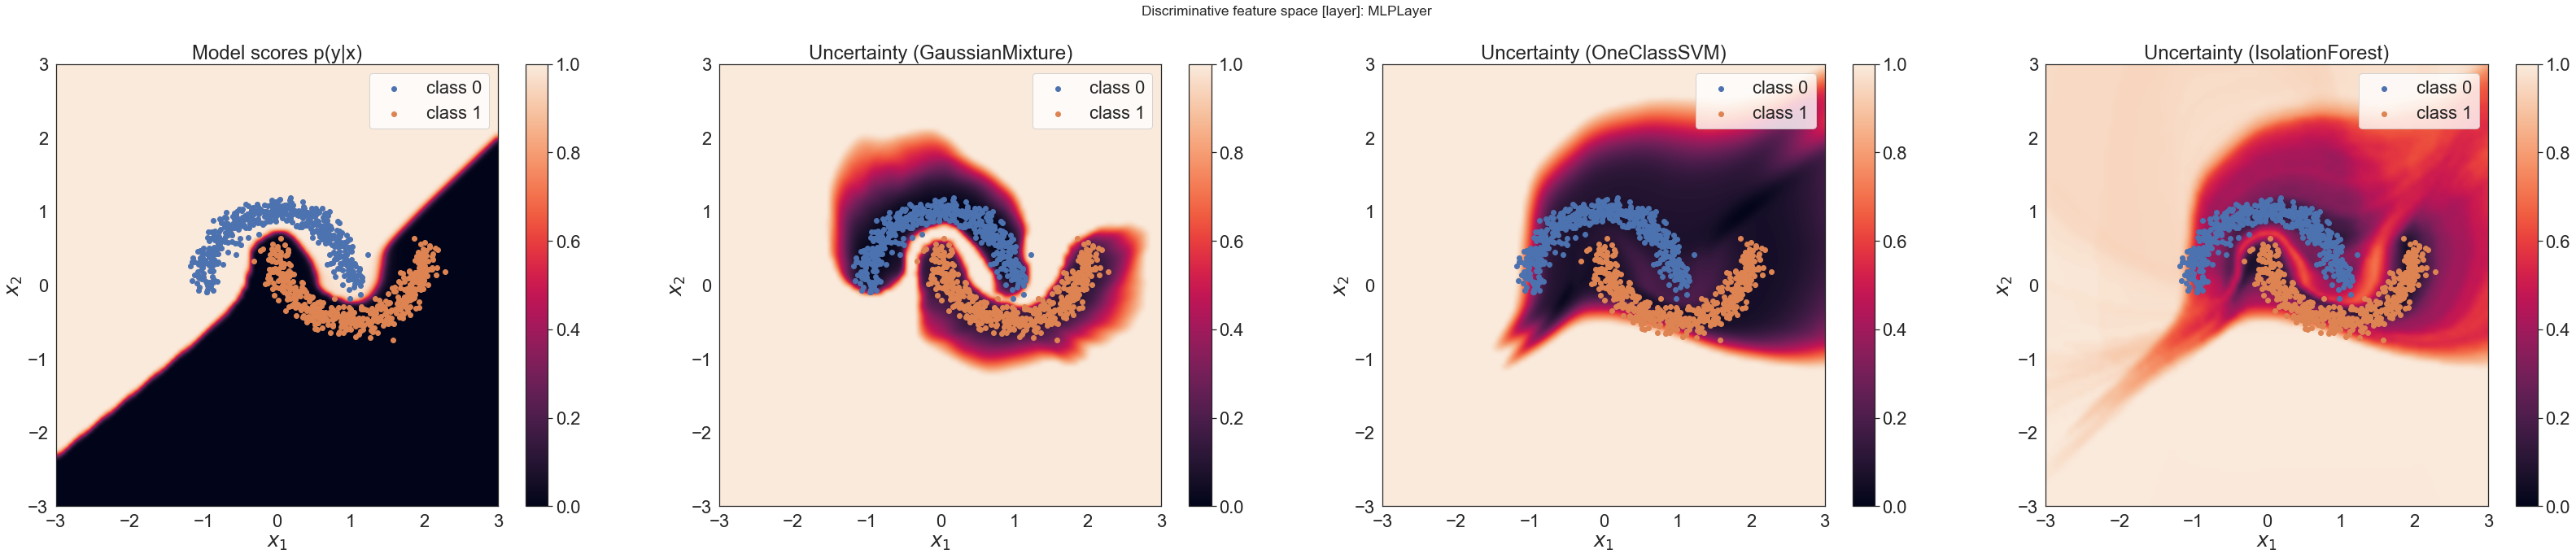

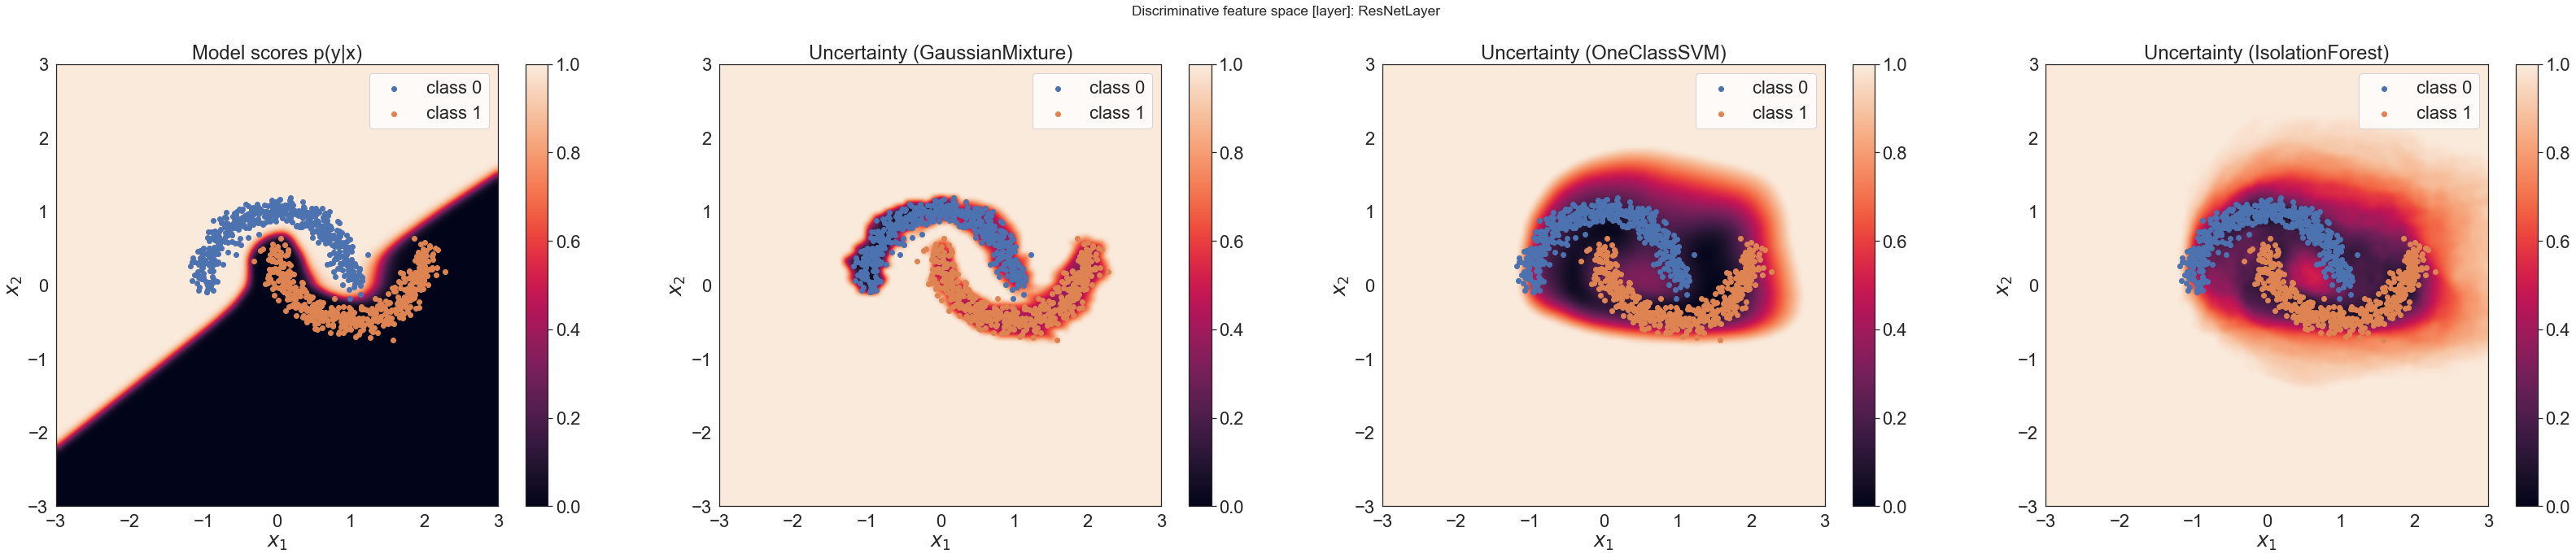

In [36]:
n_layers=10

train_and_evaluate(
    layers=[
        (ResNetSNLayer, {"norm_multiplier": 0.9}),
        (MLPLayer, {}),
        (ResNetLayer, {}),
    ],
    scorers=[
        GaussianMixture(n_components=2),
        OneClassSVM(),
        IsolationForest(),
    ],
    n_layers=n_layers
)